In [3]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
##
# @brief Computes a quadratic function.
#
# This function calculates the value of a quadratic expression \( f(x) = 3x^2 - 4x + 5 \).
#
# @param x The input value for which the function is evaluated.
# @return The result of the quadratic function for the given input.
def f(x):
    return 3 * x**2 - 4 * x + 5

In [5]:
f(3.0)

20.0

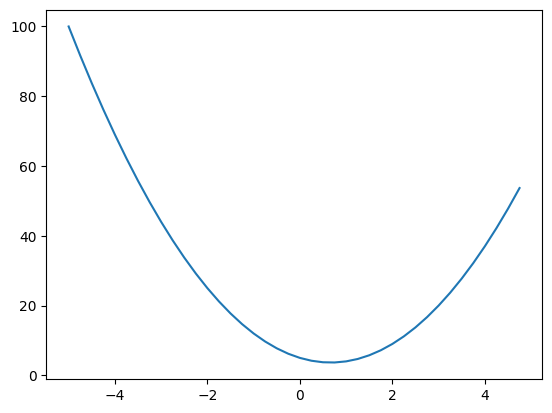

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [8]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [10]:
class Value:
    ##
    # Initializes a Value object with data, optional children, operation, and label.
    #
    # @param data The numeric value stored in this object.
    # @param _children A set of child nodes contributing to this node's value.
    # @param _op The operation that produced this node (e.g., "+", "*").
    # @param label An optional label for the value, useful for debugging or visualization.
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    ##
    # Returns a string representation of the Value object.
    #
    # @return A string showing the data of this Value.
    def __repr__(self):
        return f"Value(data={self.data})"

    ##
    # Adds another Value or numeric constant to this Value.
    #
    # @param other The other Value or numeric constant to add.
    # @return A new Value representing the result of the addition.
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    ##
    # @brief Multiplies this Value with another Value or numeric constant.
    #
    # @param other The other Value or numeric constant to multiply.
    # @return A new Value representing the result of the multiplication.
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    ##
    # @brief Raises this Value to the power of an integer or float.
    #
    # @param other The power to which to raise this Value.
    # @return A new Value representing the result of the exponentiation.
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    ##
    # @brief Multiplies another Value or constant with this Value from the left.
    #
    # @param other The other Value or constant for the left multiplication.
    # @return A new Value representing the result.
    def __rmul__(self, other):
        return self * other

    ##
    # @brief Divides this Value by another Value or numeric constant.
    #
    # @param other The other Value or numeric constant for division.
    # @return A new Value representing the result of the division.
    def __truediv__(self, other):
        return self * other**-1

    ##
    # @brief Negates this Value.
    #
    # @return A new Value that is the negative of this Value.
    def __neg__(self):
        return self * -1

    ##
    # @brief Subtracts another Value or numeric constant from this Value.
    #
    # @param other The other Value or numeric constant to subtract.
    # @return A new Value representing the result of the subtraction.
    def __sub__(self, other):
        return self + (-other)

    ##
    # @brief Adds another Value or numeric constant to this Value from the left.
    #
    # @param other The other Value or constant for the left addition.
    # @return A new Value representing the result.
    def __radd__(self, other):
        return self + other

    ##
    # @brief Applies the hyperbolic tangent function to this Value.
    #
    # @return A new Value representing the result of applying tanh to this Value.
    def tanh(self):
        import math
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    ##
    # @brief Applies the exponential function to this Value.
    #
    # @return A new Value representing the result of the exponential function.
    def exp(self):
        import math
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    ##
    # @brief Computes the gradients of all Values in the computation graph.
    #
    # This method performs a topological sort on the computation graph and backpropagates
    # gradients through each node.
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [11]:
from graphviz import Digraph

##
# Collects all nodes and edges in a computational graph.
#
# This function recursively traverses from the root node to gather all nodes and edges,
# representing the dependencies between nodes in the computational graph.
#
# @param root The root Value node to start the trace from.
# @return A tuple with two sets: one containing all nodes and one containing all edges in the graph.
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

##
# Visualizes the computational graph of a Value node using Graphviz.
#
# This function creates a left-to-right directed acyclic graph (DAG) where each node
# represents a value in the computation, showing its label, data, and gradient.
#
# @param root The root Value node for the graph to visualize.
# @return A Digraph object representing the computational graph.
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # Create a rectangular ('record') node for any value in the graph
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # Create an operation node for result values with an operation
            dot.node(name=uid + n._op, label=n._op)
            # Connect the operation node to the result value node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect each parent node to the operation node of the child
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

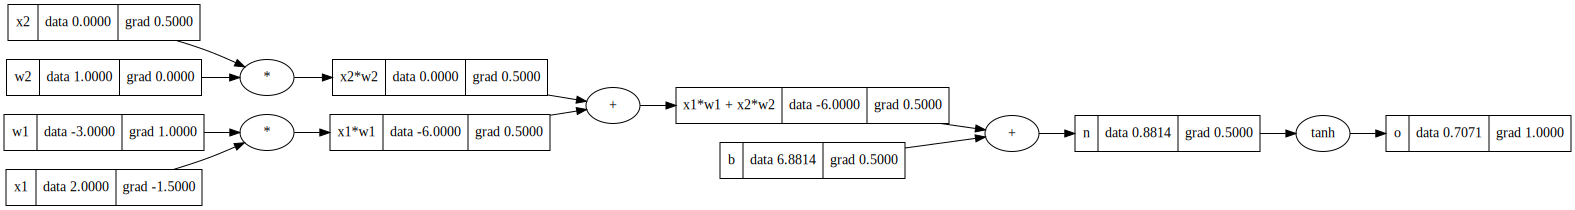

In [13]:
draw_dot(o)

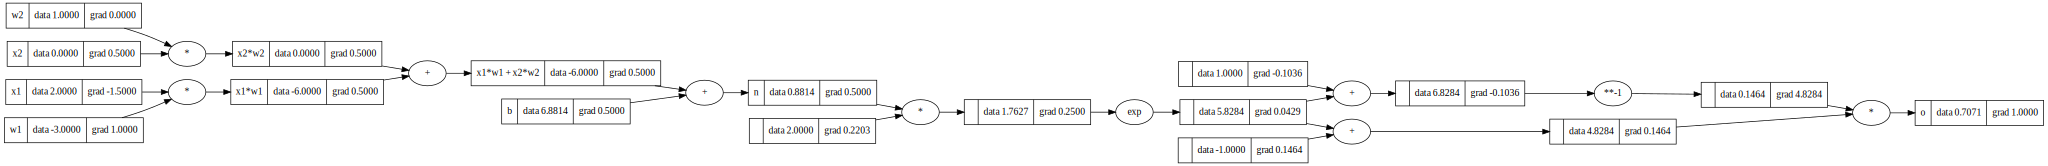

In [14]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [15]:
import torch

In [16]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [17]:
import random
from typing import List

class Neuron:
    ##
    # Initializes a Neuron with random weights and a bias.
    #
    # @param nin The number of input features to this neuron.
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    ##
    # Computes the output of the neuron for a given input.
    #
    # This function calculates the weighted sum of inputs plus bias and applies
    # the tanh activation function.
    #
    # @param x A list of input values to the neuron.
    # @return The output Value after applying the tanh activation.
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act
        return out

    ##
    # @brief Returns all parameters of the neuron (weights and bias).
    #
    # @return A list of Value objects representing the neuron's parameters.
    def parameters(self):
        return self.w + [self.b]

class Layer:
    ##
    # @brief Initializes a Layer with a specified number of neurons.
    #
    # @param nin The number of inputs to each neuron in the layer.
    # @param nout The number of neurons in this layer.
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    ##
    # @brief Computes the output of the layer for a given input.
    #
    # Calls each neuron in the layer with the input and returns their outputs.
    #
    # @param x A list of input values to the layer.
    # @return A single Value if there is one neuron, otherwise a list of output Values.
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    ##
    # @brief Returns all parameters of the layer (weights and biases of all neurons).
    #
    # @return A list of Value objects representing the layer's parameters.
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    ##
    # @brief Initializes an MLP with a specified architecture.
    #
    # @param nin The number of input features to the MLP.
    # @param nouts A list representing the number of neurons in each subsequent layer.
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    ##
    # @brief Computes the output of the MLP for a given input.
    #
    # Passes the input through each layer sequentially.
    #
    # @param x A list of input values to the MLP.
    # @return The final output Value(s) after passing through all layers.
    def __call__(self, x):
        for my_layer in self.layers:
            x = my_layer(x)
        return x

    ##
    # @brief Returns all parameters of the MLP (weights and biases of all layers).
    #
    # @return A list of Value objects representing all parameters in the MLP.
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
xs = [[2], [3], [4]]
ys = [2, 1, -2]

0 11.178798071886453
1 10.216054743380012
2 9.40154483575878
3 8.709872430263214
4 8.120058070458223
5 7.614769219462799
6 7.179684839358417
7 6.802970716109082
8 6.474846227751743
9 6.187226617890948
10 5.9334276144316265
11 5.707921527210825
12 5.5061358521318144
13 5.3242869732425735
14 5.159242845470599
15 5.008409606934387
16 4.8696379501261715
17 4.741145808190036
18 4.621454512749286
19 4.5093360753499
20 4.403769653817186
21 4.303905602726383
22 4.209035786196974
23 4.118569061599523
24 4.0320110329893435
25 3.9489473301513818
26 3.8690297988343665
27 3.7919650948411814
28 3.7175052630661405
29 3.645439955582006
30 3.5755900031660577
31 3.5078021044334005
32 3.4419444378485107
33 3.377903035824761
34 3.3155787881451584
35 3.254884965076696
36 3.195745169656881
37 3.1380916444070737
38 3.0818638707537396
39 3.0270074101946953
40 2.973472945128809
41 2.921215484600954
42 2.8701937062693377
43 2.8203694109021074
44 2.7717070698386834
45 2.724173449260114
46 2.677737297927539
47 2.

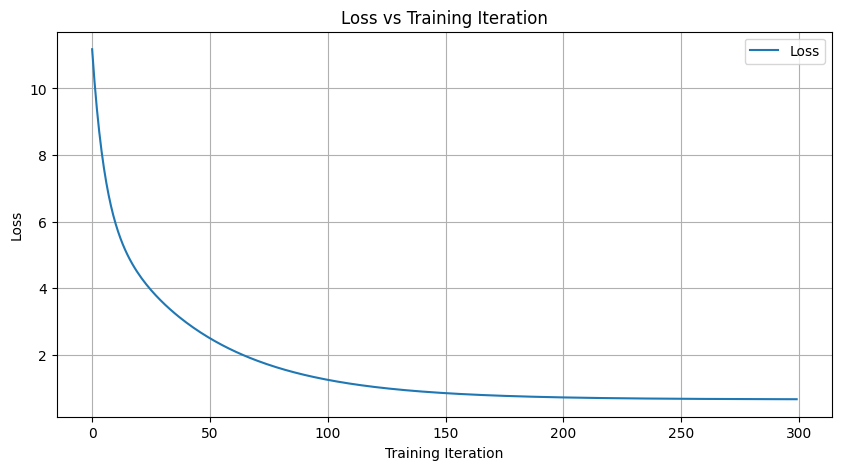

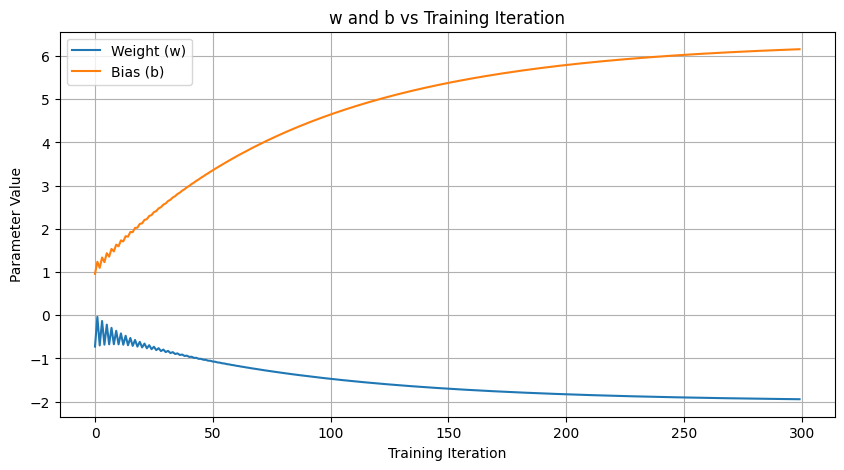

In [31]:
import random
from typing import List


loss_values=[]
w_values=[]
b_values=[]
for k in range(300):

  # forward pass
  ypred = [nn(x) for x in xs]
  # Start of backward propagation
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  loss_values.append(loss.data)
  w_values.append(nn.parameters()[0].data)  # Assuming first parameter is weight
  b_values.append(nn.parameters()[1].data)
  # backward pass
  for p in nn.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  learning_rate = 0.03
  for p in nn.parameters(): # Changed n to nn
    p.data += -learning_rate * p.grad

  print(k, loss.data)

  # Plot Loss vs. Training Iteration
plt.figure(figsize=(10, 5))
plt.plot(range(300), loss_values, label="Loss")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Training Iteration")
plt.legend()
plt.grid(True)
plt.show()

# Plot w and b vs. Training Iteration
plt.figure(figsize=(10, 5))
plt.plot(range(300), w_values, label="Weight (w)")
plt.plot(range(300), b_values, label="Bias (b)")
plt.xlabel("Training Iteration")
plt.ylabel("Parameter Value")
plt.title("w and b vs Training Iteration")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
ypred

[Value(data=2.267654927411976),
 Value(data=0.3223292797567616),
 Value(data=-1.6229963678984536)]